In [29]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [30]:
# import data modelling libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [31]:
# load the dataset
data= pd.read_csv("/content/new_test.csv")

# check shape of dataset
print("shape of the data:", data.shape)
data.head()

shape of the data: (8238, 13)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome
0,32,4,0,6,0,0,0,0,3,3,131,5,1
1,37,10,3,6,0,0,0,0,4,3,100,1,1
2,55,5,0,5,1,2,0,0,3,2,131,2,1
3,44,2,1,0,1,0,0,1,4,3,48,2,1
4,28,0,2,3,0,0,0,0,5,0,144,2,1


In [32]:
# check data types of all columns
data.dtypes

age            int64
job            int64
marital        int64
education      int64
default        int64
housing        int64
loan           int64
contact        int64
month          int64
day_of_week    int64
duration       int64
campaign       int64
poutcome       int64
dtype: object

In [33]:
import lazy_pipeline as lpipe
import matplotlib.pyplot as plt


In [34]:

from IPython.display import display, HTML
display(HTML(""))


In [35]:
data.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
poutcome       0
dtype: int64

In [36]:
from platform import python_version
import sklearn
print(python_version())
print(lpipe.pd.__version__)
print(sklearn.__version__)

3.8.16
1.3.5
1.0.2


In [37]:
y_name = 'default'

In [38]:
y = data[y_name]
X = lpipe.binarize_X(data.drop(y_name, axis=1))
print(X.shape)
X.head()


(8238, 602)


,age: 26,age: 27,age: 28,age: 29,age: 30,age: 31,age: 32,age: 33,age: 34,age: 35,...,duration: 553,duration: 554,campaign: 1,campaign: 2,campaign: 3,campaign: 4,campaign: 5,poutcome: 0,poutcome: 1,poutcome: 2
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [39]:
X = X.sample(frac=1, random_state=42)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X

In [40]:
X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
X_bin[0]

{'age: 29',
 'campaign: 1',
 'contact: 0',
 'day_of_week: 0',
 'duration: 140',
 'education: 3',
 'housing: 2',
 'job: 0',
 'loan: 0',
 'marital: 1',
 'month: 7',
 'poutcome: 1'}

In [41]:
y = y.values.tolist()

In [42]:
n_train = int(len(X)*0.1)
n_test = len(X) - n_train
n_train, n_test


(823, 7415)

In [43]:
y_test = y[n_train:]


In [57]:
# indentifying the categorical variables
cat_var= data.select_dtypes(include= ["object"]).columns
print(cat_var)

# plotting bar chart for each categorical variable
plt.style.use("ggplot")

for column in cat_var:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    data[column].value_counts().plot(kind="bar")
    plt.xlabel(column)
    plt.ylabel("number of customers")
    plt.title(column)

Index([], dtype='object')


In [59]:
# replacing "unknown" with the mode
for column in cat_var:
    mode= data[column].mode()[0]
    data[column]= data[column].replace("unknown", mode)

In [45]:
%%time
gen = lpipe.predict_array(X_bin, y, n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 8238/8238 [3:59:55<00:00,  1.94s/it]

CPU times: user 3h 58min 29s, sys: 32.7 s, total: 3h 59min 2s
Wall time: 3h 59min 55s


In [46]:
%%time
gen = list(lpipe.predict_array(X_bin, y, n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 8238/8238 [06:38<00:00, 18.63it/s]

CPU times: user 6min 33s, sys: 1.92 s, total: 6min 35s
Wall time: 6min 38s


In [47]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
    preds = y_preds
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]


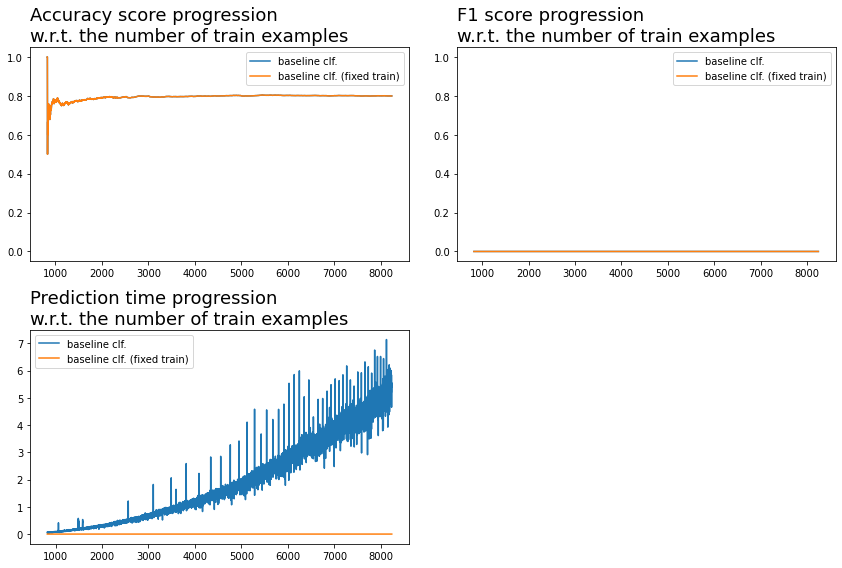

In [55]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison.png')
plt.show()


     


In [62]:
# indentifying the numerical variables
num_var= data.select_dtypes(include=np.number)
num_var.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome
0,32,4,0,6,0,0,0,0,3,3,131,5,1
1,37,10,3,6,0,0,0,0,4,3,100,1,1
2,55,5,0,5,1,2,0,0,3,2,131,2,1
3,44,2,1,0,1,0,0,1,4,3,48,2,1
4,28,0,2,3,0,0,0,0,5,0,144,2,1


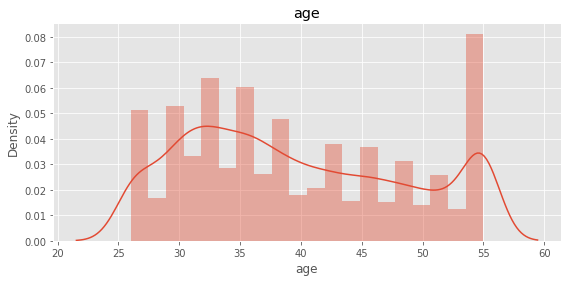

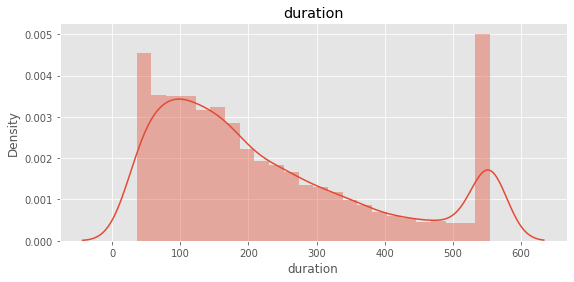

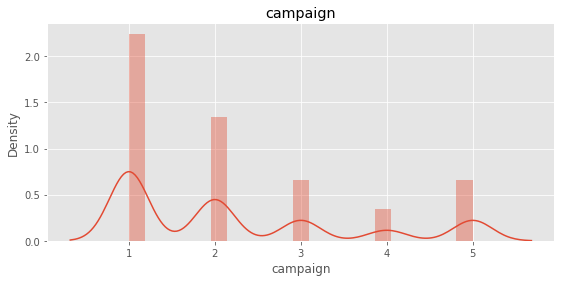

In [63]:
# plotting histogram for each numerical variable
plt.style.use("ggplot")
for column in ["age", "duration", "campaign"]:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.distplot(data[column], kde=True)
    plt.title(column)

In [65]:
plt.style.use("ggplot")
for column in cat_var:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.countplot(data[column], hue=data["y"])
    plt.title(column)    
    plt.xticks(rotation=90)

In [67]:
data.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome
count,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000
mean,39.613498,3.729425,1.170430,3.740592,0.201141,1.072833,0.320952,0.364409,4.220685,2.020879,227.820588,2.207575,0.932629
std,9.021371,3.597274,0.610371,2.134617,0.400878,0.985527,0.717918,0.481293,2.321464,1.386752,160.447506,1.380902,0.357648
min,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000,1.000000,0.000000
25%,32.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,101.000000,1.000000,1.000000
50%,38.000000,2.000000,1.000000,3.000000,0.000000,2.000000,0.000000,0.000000,4.000000,2.000000,178.000000,2.000000,1.000000
75%,47.000000,7.000000,2.000000,6.000000,0.000000,2.000000,0.000000,1.000000,6.000000,3.000000,319.000000,3.000000,1.000000
max,55.000000,11.000000,3.000000,7.000000,1.000000,2.000000,2.000000,1.000000,9.000000,4.000000,554.000000,5.000000,2.000000


In [68]:
# compute interquantile range to calculate the boundaries
lower_boundries= []
upper_boundries= []
for i in ["age", "duration", "campaign"]:
    IQR= data[i].quantile(0.75) - data[i].quantile(0.25)
    lower_bound= data[i].quantile(0.25) - (1.5*IQR)
    upper_bound= data[i].quantile(0.75) + (1.5*IQR)
    
    print(i, ":", lower_bound, ",",  upper_bound)
    
    lower_boundries.append(lower_bound)
    upper_boundries.append(upper_bound)

age : 9.5 , 69.5
duration : -226.0 , 646.0
campaign : -2.0 , 6.0


In [69]:
lower_boundries

[9.5, -226.0, -2.0]

In [70]:
upper_boundries

[69.5, 646.0, 6.0]

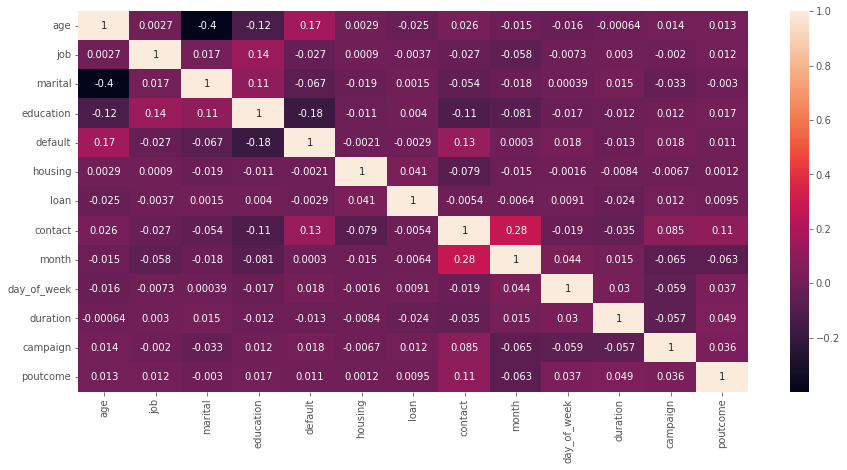

In [71]:
plt.figure(figsize=(15,7))
sns.heatmap(data.corr(), annot=True)